# 🧠 Visualisation des Activations Intermédiaires du CNN

Ce notebook charge le modèle v4.0.0 (50 catégories) et visualise les feature maps à différents niveaux:
- **Couche 1-2**: Détection des edges, lignes, courbes
- **Couche 3-4**: Détection des formes simples (cercles, carrés)
- **Couche 5-6**: Détection des parties d'objets
- **Dense**: Décision finale

Cela permet de comprendre la hiérarchie des features apprises par le réseau.

In [42]:
# Import des bibliothèques
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tensorflow import keras
from tensorflow.keras import models
import json
import os

## 1. Chargement du Modèle et des Métadonnées

In [43]:
# Chemins
MODEL_PATH = '../logs/pro_cnn_50_class/quickdraw_v4.0.0_50cat.h5'
METADATA_PATH = '../logs/pro_cnn_50_class/quickdraw_v4.0.0_50cat_metadata.json'
DATASET_PATH = '../data/quickdraw_20cat.h5'  # Pour charger des exemples

# Chargement du modèle
print("Chargement du modèle...")
model = keras.models.load_model(MODEL_PATH)
print(f"✓ Modèle chargé: {MODEL_PATH}")

# Chargement des métadonnées
with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)
    
class_names = metadata["categories"]
print(f"✓ Nombre de catégories: {len(class_names)}")
print(f"✓ Exemples: {class_names[:10]}")

Chargement du modèle...


✓ Modèle chargé: ../logs/pro_cnn_50_class/quickdraw_v4.0.0_50cat.h5
✓ Nombre de catégories: 345
✓ Exemples: ['aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm']


## 2. Architecture du Modèle

In [44]:
# Affichage de l'architecture
model.summary()

# Liste des couches convolutionnelles
conv_layers = [layer for layer in model.layers if 'conv' in layer.name]
print(f"\n🔍 Couches convolutionnelles trouvées: {len(conv_layers)}")
for i, layer in enumerate(conv_layers, 1):
    print(f"  {i}. {layer.name} - Output: {layer.output.shape}")

Model: "QuickDraw_DeepCNN_50cat"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,350,068 (8.96 MB)

 Trainable params: 2,350,066 (8.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)


🔍 Couches convolutionnelles trouvées: 6
  1. conv2d_1 - Output: (None, 28, 28, 64)
  2. conv2d_2 - Output: (None, 28, 28, 64)
  3. conv2d_3 - Output: (None, 14, 14, 128)
  4. conv2d_4 - Output: (None, 14, 14, 128)
  5. conv2d_5 - Output: (None, 7, 7, 256)
  6. conv2d_6 - Output: (None, 7, 7, 256)


## 3. Chargement d'Images de Test

On charge quelques exemples du dataset pour visualiser les activations.

In [45]:
# Chargement du dataset de test
print("Chargement du dataset...")
with h5py.File(DATASET_PATH, 'r') as f:
    # Charger quelques exemples de test
    X_test = f['X_test'][:100]  # 100 premiers exemples
    y_test = f['y_test'][:100]

print(f"✓ Forme X_test: {X_test.shape}")
print(f"✓ Forme y_test: {y_test.shape}")

# Sélectionner quelques exemples intéressants (un par catégorie)
examples = {}
for i, label in enumerate(y_test):
    if label not in examples:
        examples[label] = X_test[i]
    if len(examples) >= 10:  # 10 exemples max
        break

print(f"\n✓ {len(examples)} exemples sélectionnés")

Chargement du dataset...
✓ Forme X_test: (100, 28, 28, 1)
✓ Forme y_test: (100,)

✓ 10 exemples sélectionnés


## 4. Visualisation des Images d'Origine

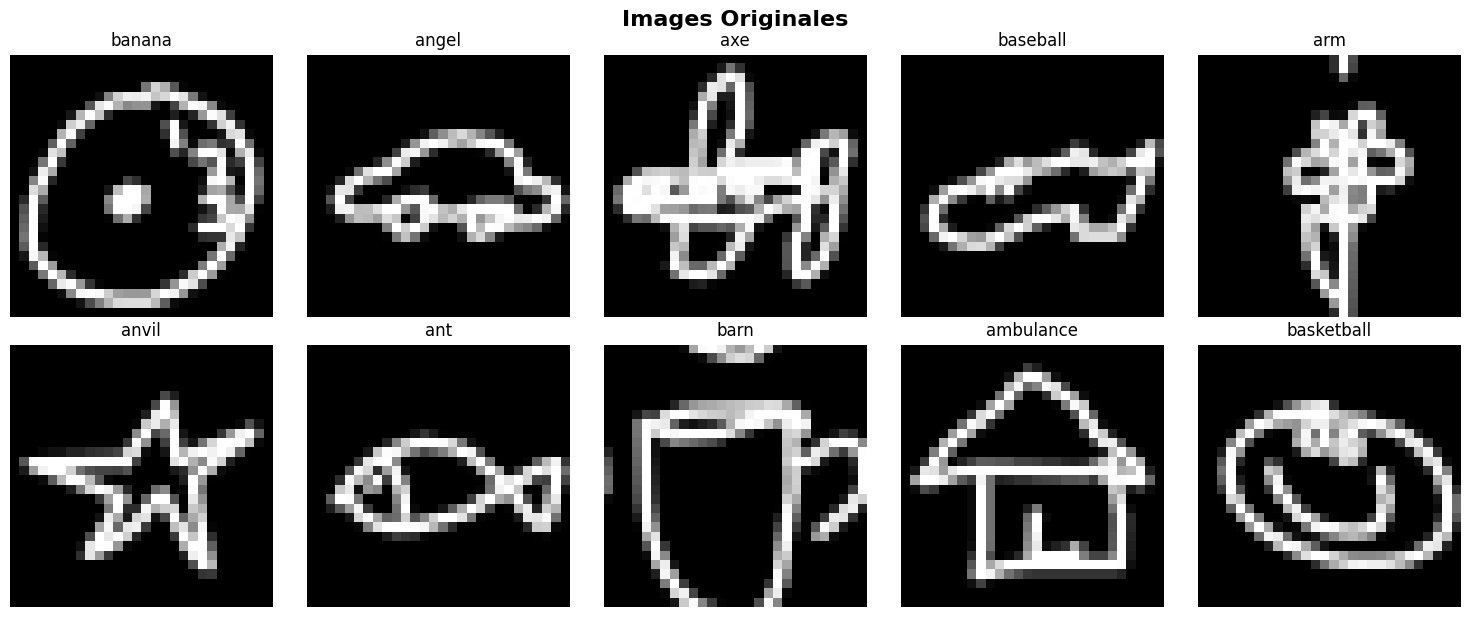

In [46]:
# Affichage des images originales
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for idx, (label, img) in enumerate(list(examples.items())[:10]):
    axes[idx].imshow(img.squeeze(), cmap='gray')
    axes[idx].set_title(f"{class_names[label]}")
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Images Originales', y=1.02, fontsize=16, fontweight='bold')
plt.show()

## 5. Création des Modèles Intermédiaires

On crée des modèles qui sortent les activations à différentes couches.

In [47]:
# Sélection des couches à visualiser
layer_names = [
    'conv2d_1',    # Première couche conv - Edges/lignes
    'conv2d_2',    # Deuxième couche conv
    'conv2d_3',    # Troisième couche - Formes simples
    'conv2d_4',    # Quatrième couche
    'conv2d_5',    # Cinquième couche - Parties d'objets
    'conv2d_6',    # Sixième couche
]

# Créer un input explicite pour le modèle d'activation
input_layer = keras.Input(shape=(28, 28, 1))

# Construire le modèle d'activation en passant l'input à travers les couches
x = input_layer
layer_outputs = []

for layer in model.layers:
    x = layer(x)
    if layer.name in layer_names:
        layer_outputs.append(x)

# Création du modèle intermédiaire
activation_model = models.Model(inputs=input_layer, outputs=layer_outputs)

print("✓ Modèles d'activation créés pour:")
for i, name in enumerate(layer_names):
    print(f"  - {name}: {layer_outputs[i].shape}")

✓ Modèles d'activation créés pour:
  - conv2d_1: (None, 28, 28, 64)
  - conv2d_2: (None, 28, 28, 64)
  - conv2d_3: (None, 14, 14, 128)
  - conv2d_4: (None, 14, 14, 128)
  - conv2d_5: (None, 7, 7, 256)
  - conv2d_6: (None, 7, 7, 256)


## 6. Fonction de Visualisation des Feature Maps

In [48]:
def visualize_activations(img, class_name, max_filters=16):
    """
    Visualise les activations de toutes les couches pour une image donnée.
    
    Args:
        img: Image (28, 28, 1)
        class_name: Nom de la classe
        max_filters: Nombre maximum de filtres à afficher par couche
    """
    # Prédiction et activations
    img_batch = np.expand_dims(img, axis=0)  # (1, 28, 28, 1)
    activations = activation_model.predict(img_batch, verbose=0)
    
    # Prédiction finale
    prediction = model.predict(img_batch, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class] * 100
    
    print(f"\n{'='*80}")
    print(f"Image: {class_name}")
    print(f"Prédiction: {class_names[predicted_class]} ({confidence:.1f}%)")
    print(f"{'='*80}\n")
    
    # Visualisation de chaque couche
    for layer_name, activation in zip(layer_names, activations):
        n_features = activation.shape[-1]
        n_to_display = min(n_features, max_filters)
        size = activation.shape[1]
        
        # Calculer la grille
        n_cols = 8
        n_rows = (n_to_display + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 2*n_rows))
        axes = axes.ravel() if n_rows > 1 else [axes] if n_cols == 1 else axes
        
        for i in range(n_to_display):
            axes[i].imshow(activation[0, :, :, i], cmap='viridis')
            axes[i].set_title(f'Filtre {i+1}')
            axes[i].axis('off')
        
        # Cacher les axes non utilisés
        for i in range(n_to_display, len(axes)):
            axes[i].axis('off')
        
        plt.suptitle(f'{layer_name} - {n_features} filtres ({size}×{size})', 
                     fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
    return prediction

## 7. Visualisation: Couche 1-2 (Edges et Lignes)

Les premières couches détectent les features de bas niveau: edges horizontaux, verticaux, diagonaux, courbes.

🎨 Visualisation des activations pour: banana


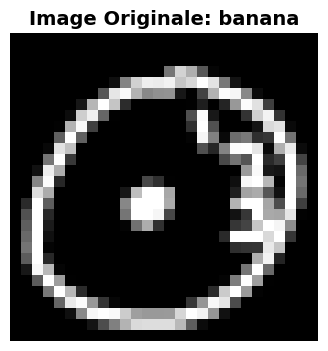


Image: banana
Prédiction: boomerang (96.5%)



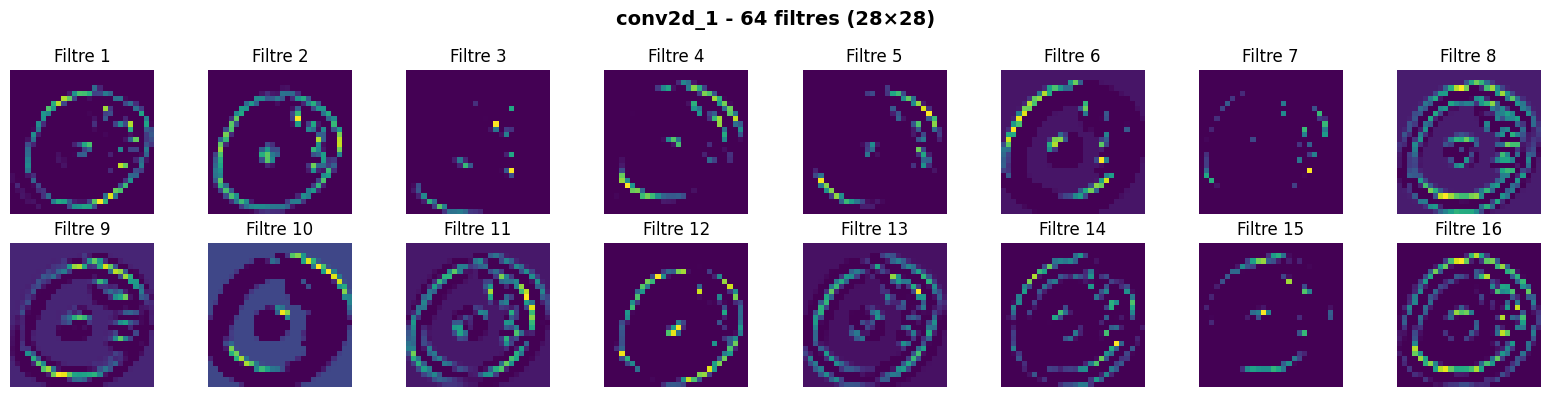

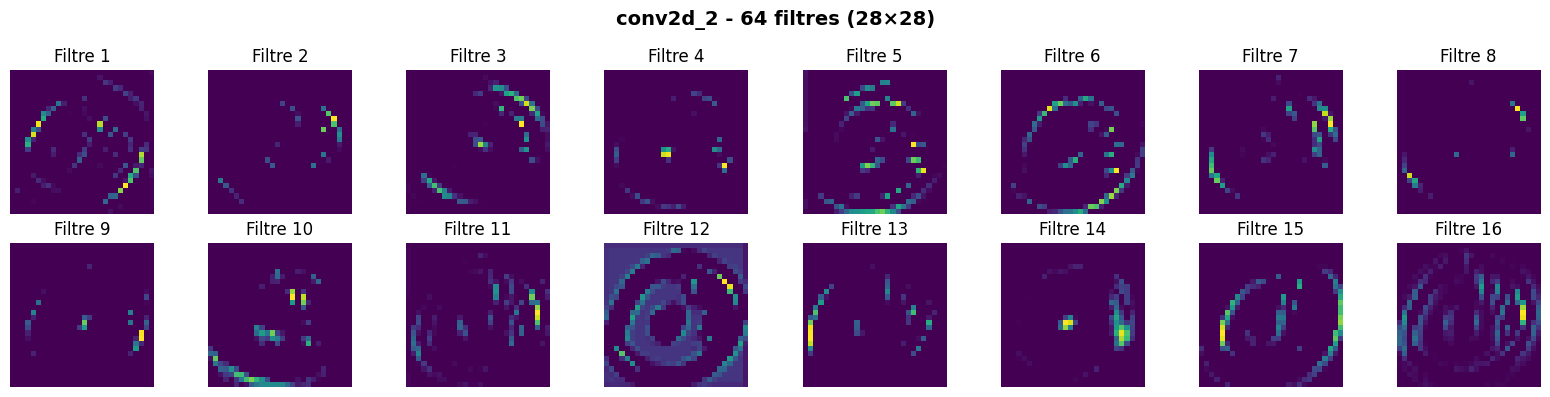

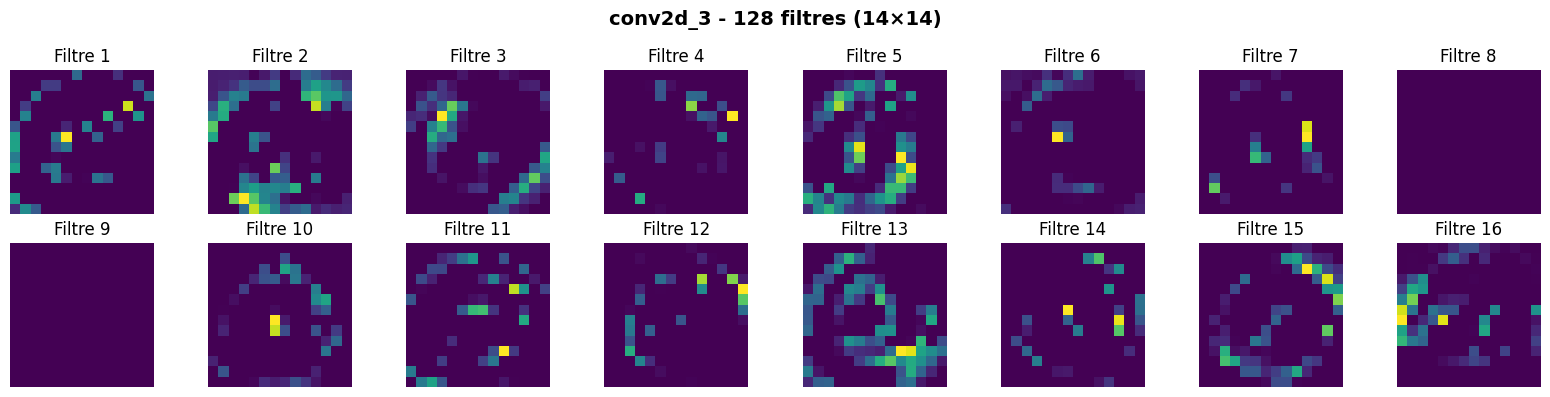

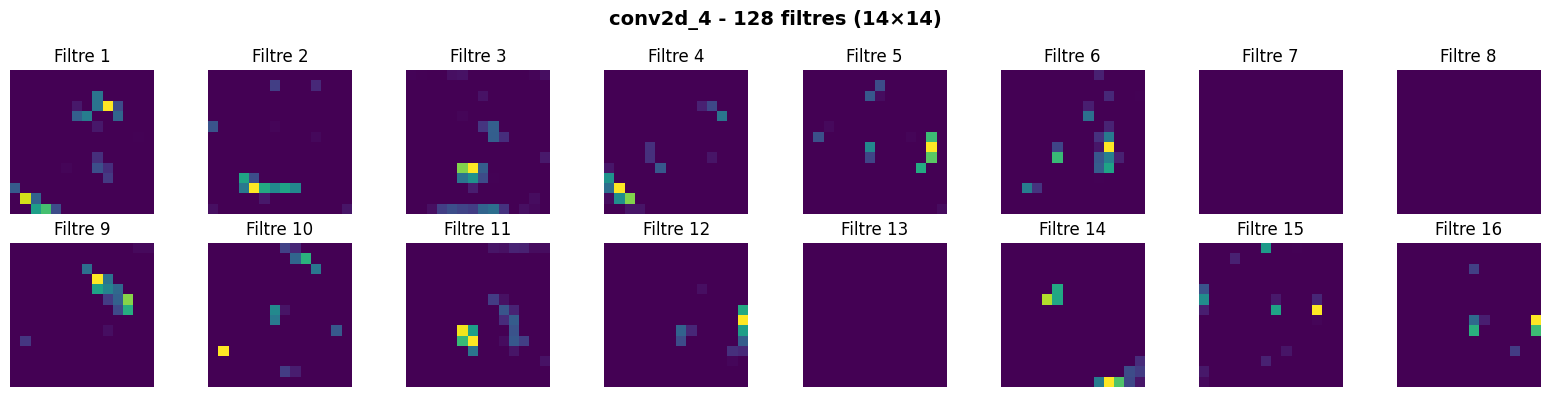

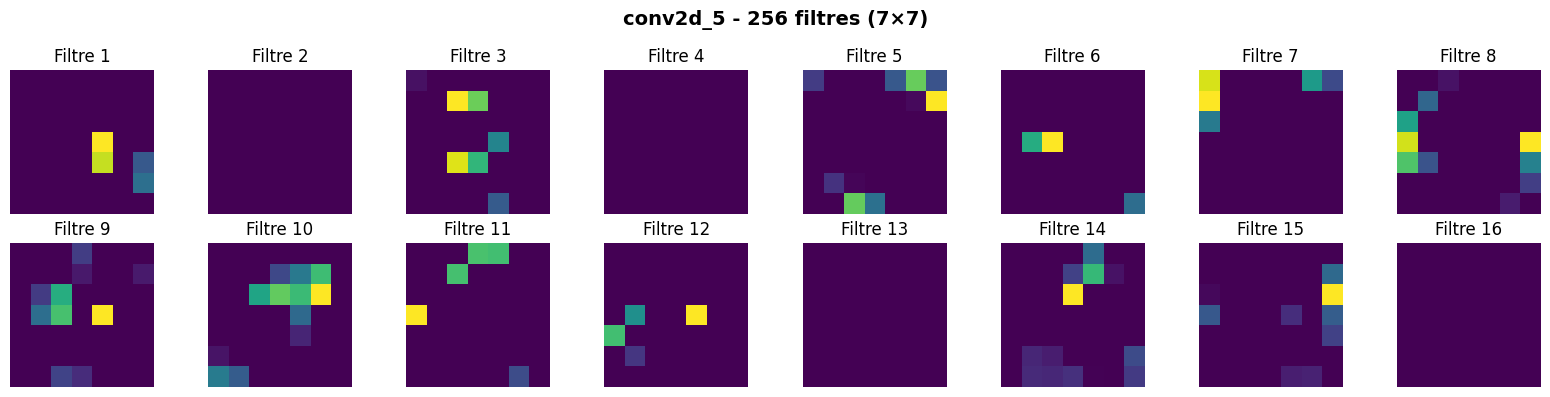

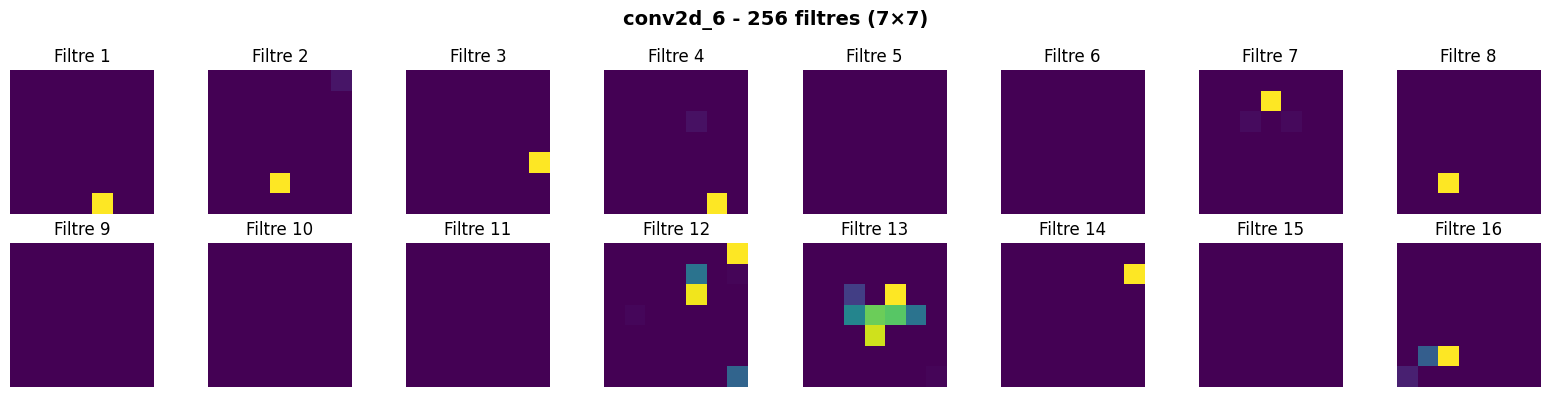

In [49]:
# Sélectionner une image intéressante (ex: chat)
sample_label = list(examples.keys())[0]
sample_img = examples[sample_label]
sample_class = class_names[sample_label]

print(f"🎨 Visualisation des activations pour: {sample_class}")

# Afficher l'image originale
plt.figure(figsize=(4, 4))
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.title(f'Image Originale: {sample_class}', fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()

# Visualiser toutes les activations
prediction = visualize_activations(sample_img, sample_class, max_filters=16)

## 8. Comparaison sur Plusieurs Exemples

## 8. Visualisation Style "Pipeline" (comme l'image de référence)

Visualisation compacte montrant la progression des activations à travers les couches, avec toutes les feature maps en grille.

🎨 Visualisation style pipeline pour différentes images:


EXEMPLE 1: banana



/var/folders/c6/64y_62t91hb49j5j4h683t100000gn/T/ipykernel_49110/782293283.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


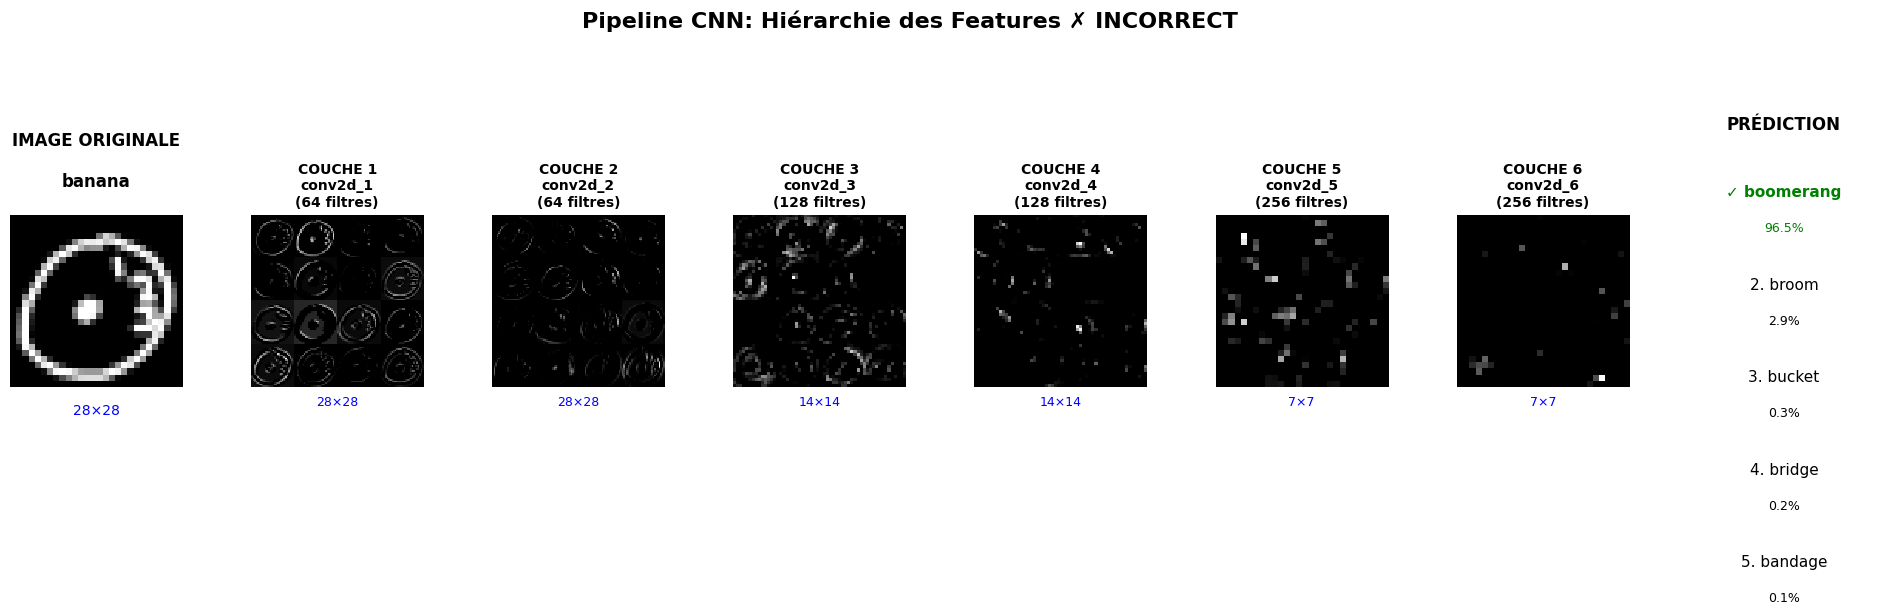


EXEMPLE 2: angel



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

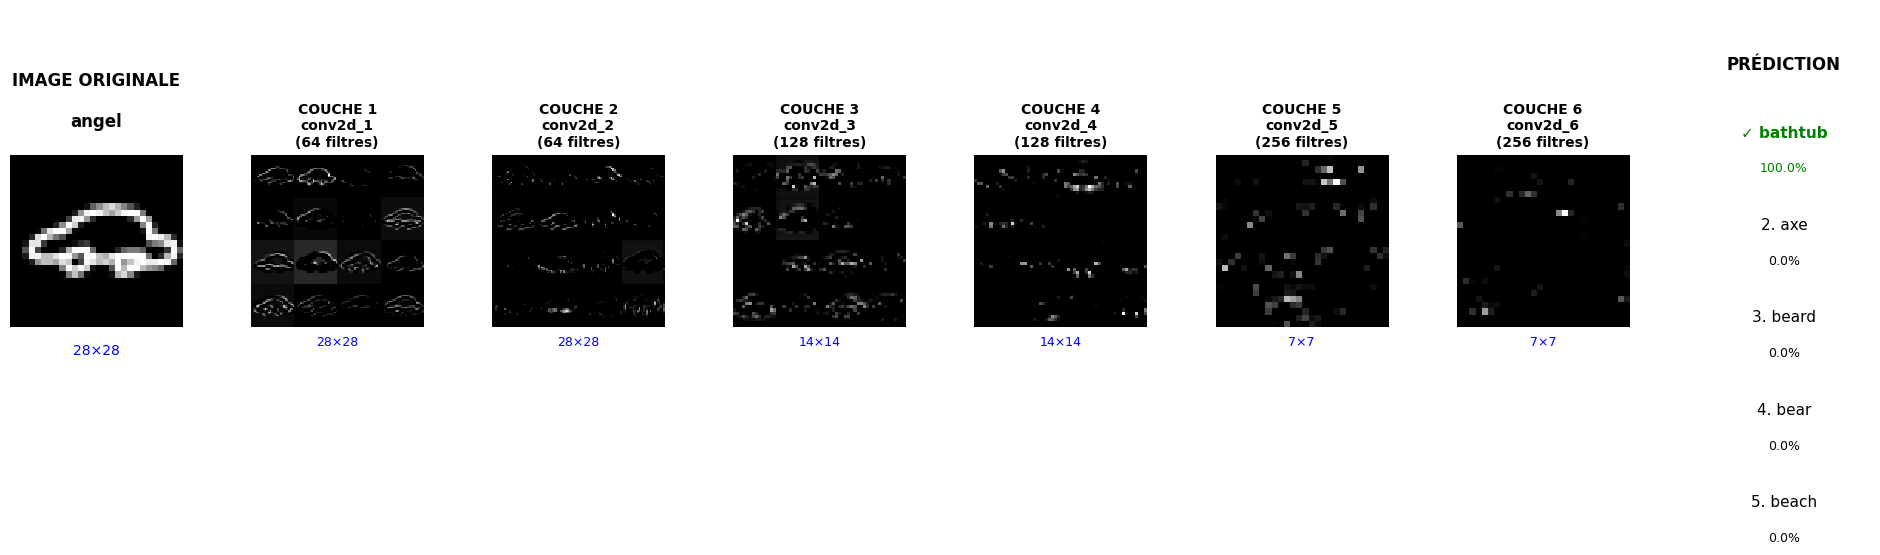

In [50]:
def visualize_cnn_pipeline(img, class_name, filters_per_layer=16):
    """
    Visualise la progression des activations à travers le CNN de manière compacte.
    Style: Image originale → Grille de feature maps pour chaque couche → Prédiction
    
    Args:
        img: Image (28, 28, 1)
        class_name: Nom de la classe
        filters_per_layer: Nombre de filtres à afficher par couche
    """
    # Prédiction et activations
    img_batch = np.expand_dims(img, axis=0)
    activations = activation_model.predict(img_batch, verbose=0)
    prediction = model.predict(img_batch, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class] * 100
    
    # Créer la figure
    n_layers = len(layer_names)
    fig = plt.figure(figsize=(24, 6))
    
    # Configuration de la grille
    gs = fig.add_gridspec(2, n_layers + 2, hspace=0.3, wspace=0.4)
    
    # 1. Image originale (occupe 2 lignes)
    ax_orig = fig.add_subplot(gs[:, 0])
    ax_orig.imshow(img.squeeze(), cmap='gray')
    ax_orig.set_title(f'IMAGE ORIGINALE\n\n{class_name}', 
                      fontsize=12, fontweight='bold', pad=20)
    ax_orig.axis('off')
    ax_orig.text(0.5, -0.1, '28×28', ha='center', va='top', 
                 transform=ax_orig.transAxes, fontsize=10, color='blue')
    
    # 2. Feature maps pour chaque couche
    for layer_idx, (layer_name, activation) in enumerate(zip(layer_names, activations)):
        n_filters = activation.shape[-1]
        size = activation.shape[1]
        
        # Calculer la grille pour cette couche (4 lignes × 4 colonnes)
        rows, cols = 4, 4
        n_to_display = min(n_filters, filters_per_layer)
        
        # Créer une grille composite des feature maps
        grid_size = int(np.ceil(np.sqrt(n_to_display)))
        composite = np.zeros((grid_size * size, grid_size * size))
        
        for i in range(n_to_display):
            row_idx = i // grid_size
            col_idx = i % grid_size
            if i < n_filters:
                feature_map = activation[0, :, :, i]
                composite[row_idx*size:(row_idx+1)*size, 
                         col_idx*size:(col_idx+1)*size] = feature_map
        
        # Afficher la grille composite
        ax = fig.add_subplot(gs[:, layer_idx + 1])
        im = ax.imshow(composite, cmap='gray', interpolation='nearest')
        ax.set_title(f'COUCHE {layer_idx + 1}\n{layer_name}\n({n_filters} filtres)', 
                    fontsize=10, fontweight='bold')
        ax.axis('off')
        ax.text(0.5, -0.05, f'{size}×{size}', ha='center', va='top', 
               transform=ax.transAxes, fontsize=9, color='blue')
    
    # 3. Prédiction finale (occupe 2 lignes)
    ax_pred = fig.add_subplot(gs[:, -1])
    ax_pred.axis('off')
    
    # Afficher le top 5 des prédictions
    top_5_indices = np.argsort(prediction[0])[-5:][::-1]
    
    y_pos = 0.9
    ax_pred.text(0.5, y_pos, 'PRÉDICTION', ha='center', va='top',
                fontsize=12, fontweight='bold', transform=ax_pred.transAxes)
    y_pos -= 0.15
    
    for i, idx in enumerate(top_5_indices):
        prob = prediction[0][idx] * 100
        color = 'green' if i == 0 else 'black'
        weight = 'bold' if i == 0 else 'normal'
        marker = '✓' if i == 0 else f'{i+1}.'
        
        ax_pred.text(0.5, y_pos, f'{marker} {class_names[idx]}', 
                    ha='center', va='top', fontsize=11, 
                    color=color, weight=weight, transform=ax_pred.transAxes)
        y_pos -= 0.08
        ax_pred.text(0.5, y_pos, f'{prob:.1f}%', 
                    ha='center', va='top', fontsize=9, 
                    color=color, transform=ax_pred.transAxes)
        y_pos -= 0.12
    
    # Titre global
    correctness = "✓ CORRECT" if predicted_class == list(examples.keys())[list(examples.values()).index(img)] else "✗ INCORRECT"
    fig.suptitle(f'Pipeline CNN: Hiérarchie des Features {correctness}', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    return prediction

# Visualiser quelques exemples
print("🎨 Visualisation style pipeline pour différentes images:\n")
for idx, (label, img) in enumerate(list(examples.items())[:3]):
    print(f"\n{'='*100}")
    print(f"EXEMPLE {idx+1}: {class_names[label]}")
    print(f"{'='*100}\n")
    visualize_cnn_pipeline(img, class_names[label], filters_per_layer=16)

## 9. Comparaison sur Plusieurs Exemples (vue détaillée)


################################################################################
EXEMPLE 1/3
################################################################################


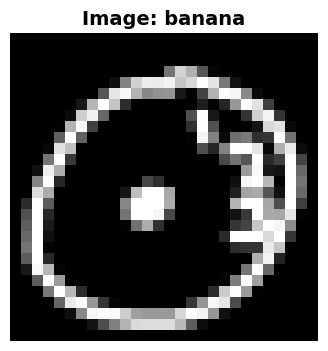


Image: banana
Prédiction: boomerang (96.5%)



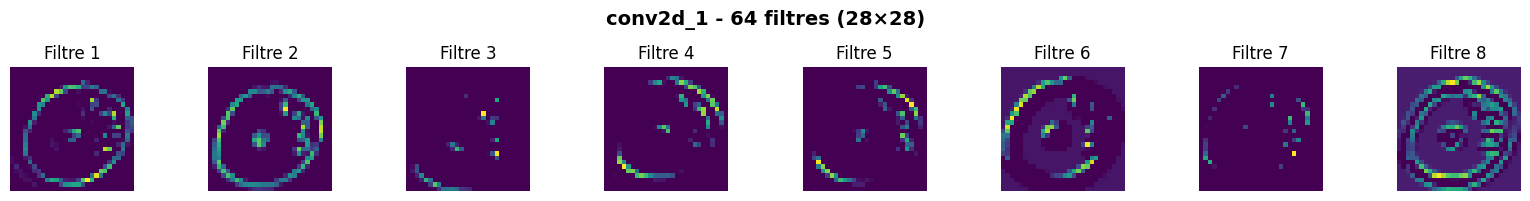

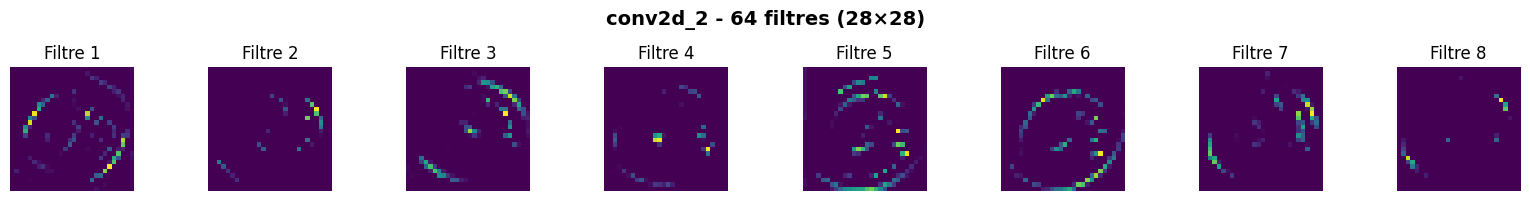

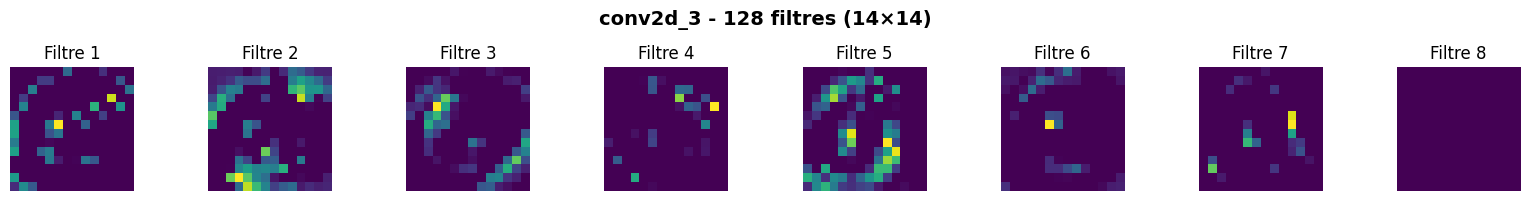

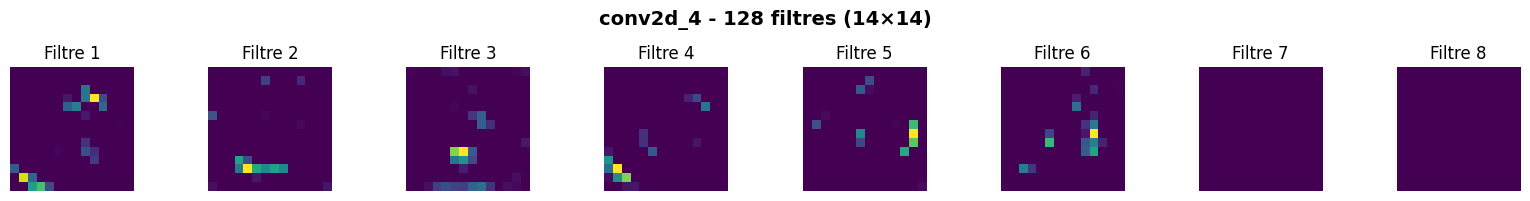

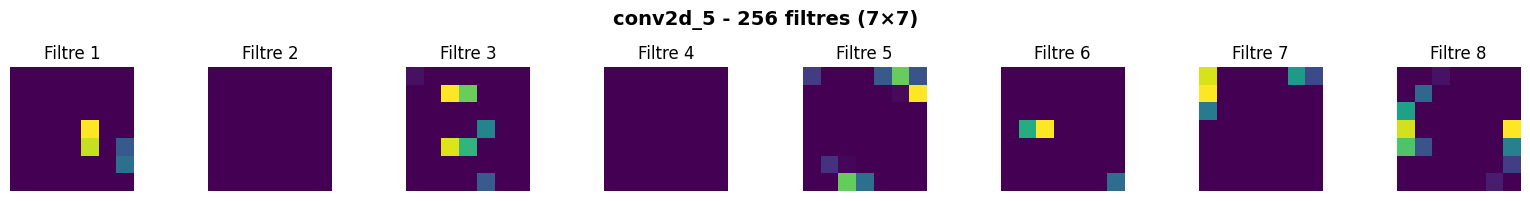

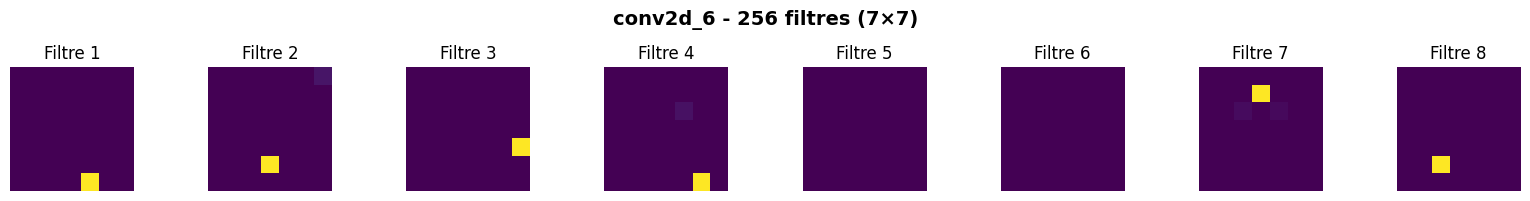


################################################################################
EXEMPLE 2/3
################################################################################


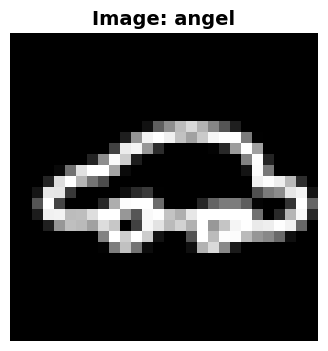


Image: angel
Prédiction: bathtub (100.0%)



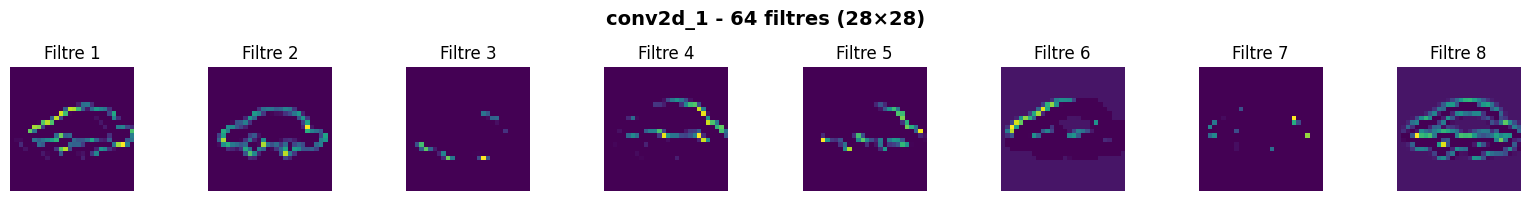

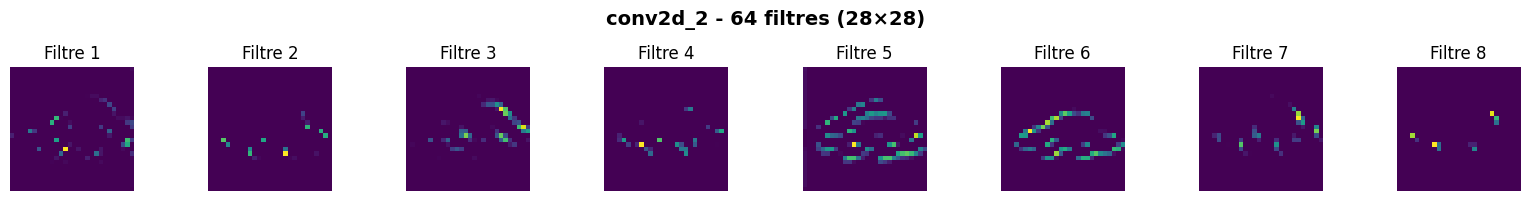

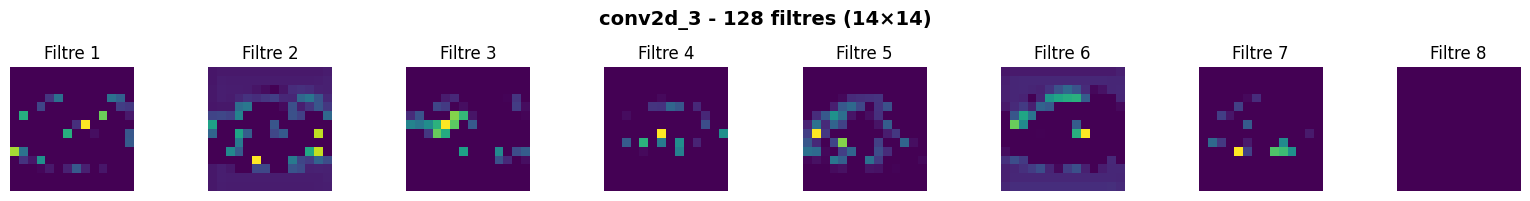

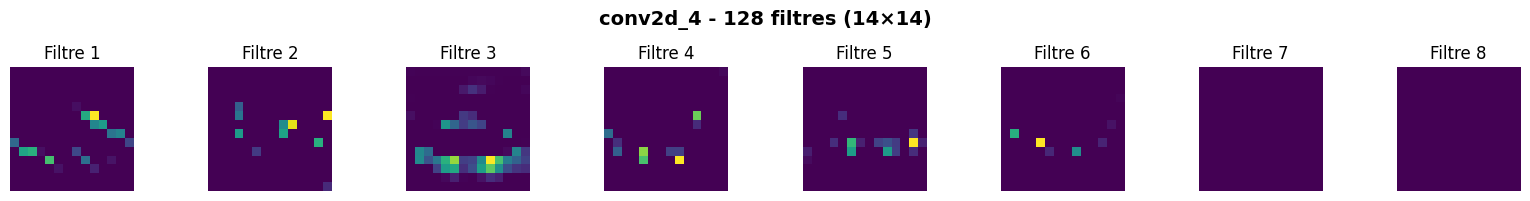

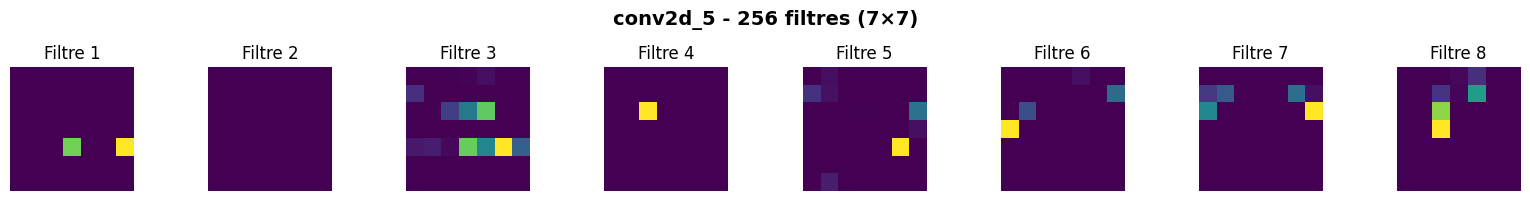

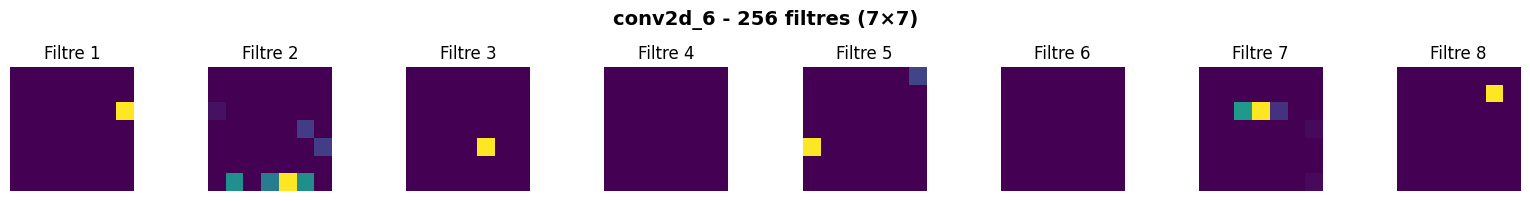


################################################################################
EXEMPLE 3/3
################################################################################


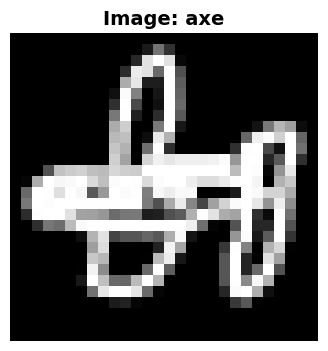


Image: axe
Prédiction: bat (87.0%)



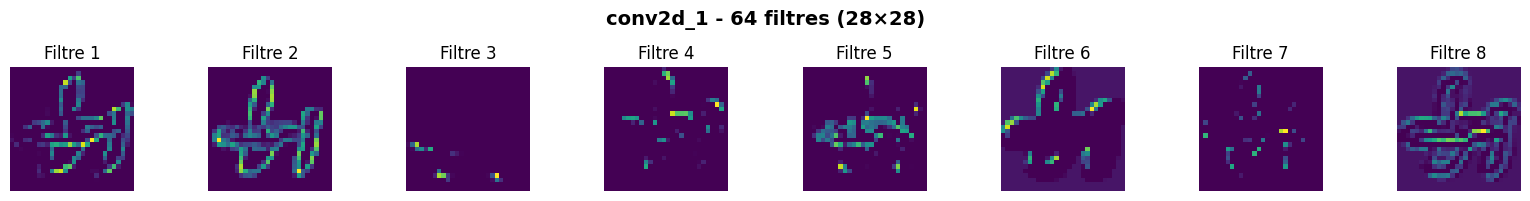

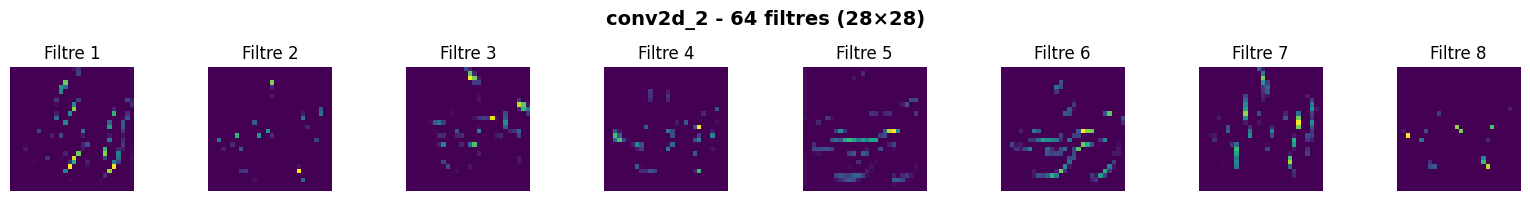

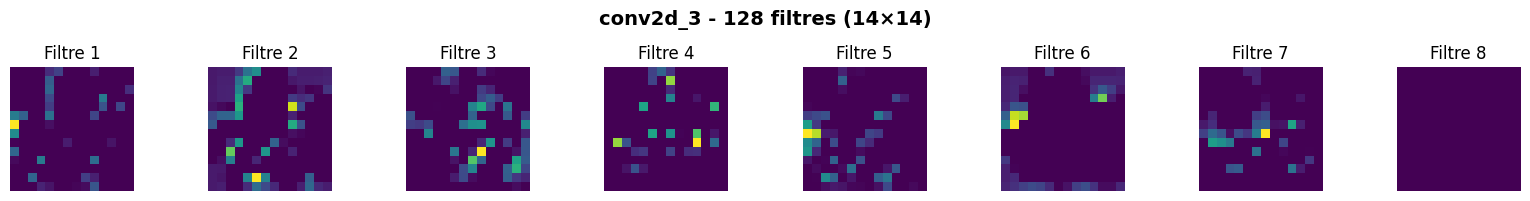

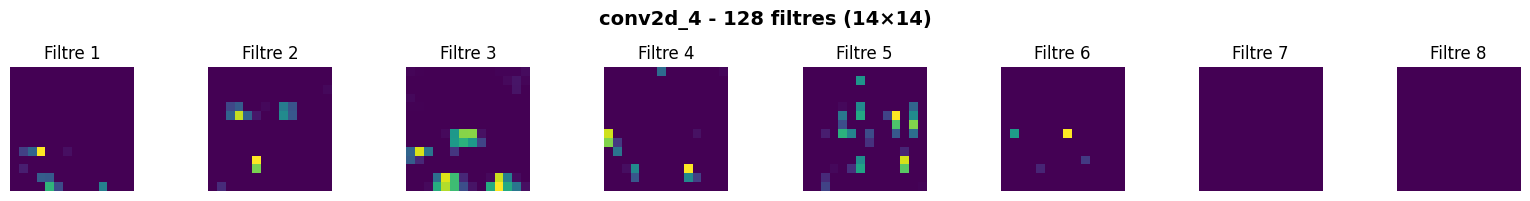

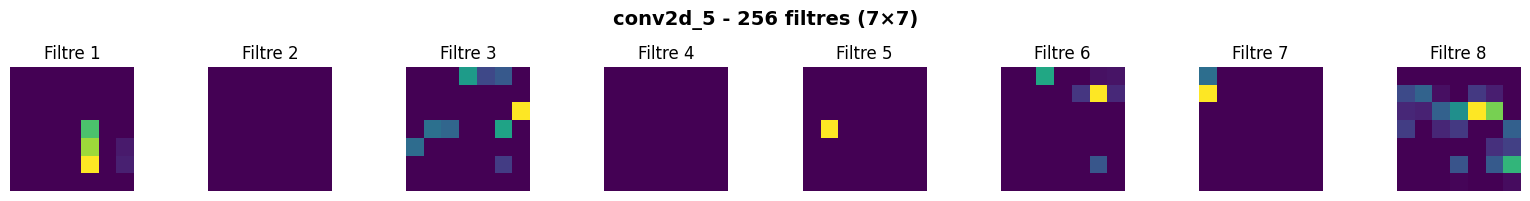

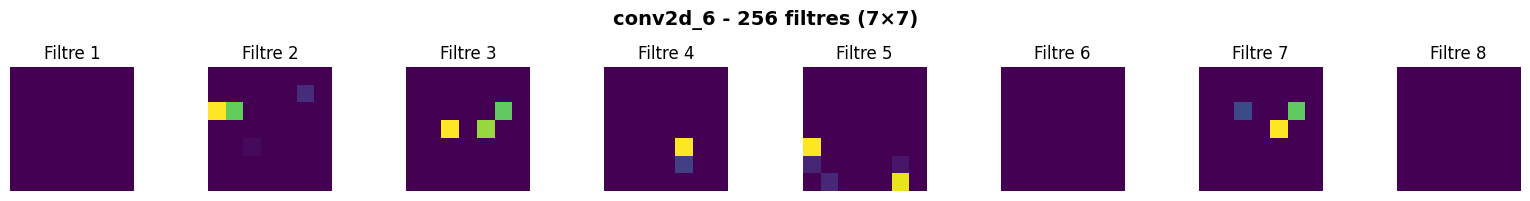

In [ ]:
# Visualiser 3 exemples différents
for idx, (label, img) in enumerate(list(examples.items())[:3]):
    print(f"\n{'#'*80}")
    print(f"EXEMPLE {idx+1}/3")
    print(f"{'#'*80}")
    
    # Afficher l'image originale
    plt.figure(figsize=(4, 4))
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Image: {class_names[label]}', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.show()
    
    # Visualiser les activations
    visualize_activations(img, class_names[label], max_filters=8)

## 9. Visualisation Comparative des Couches

Comparaison côte à côte de toutes les couches pour une même image.

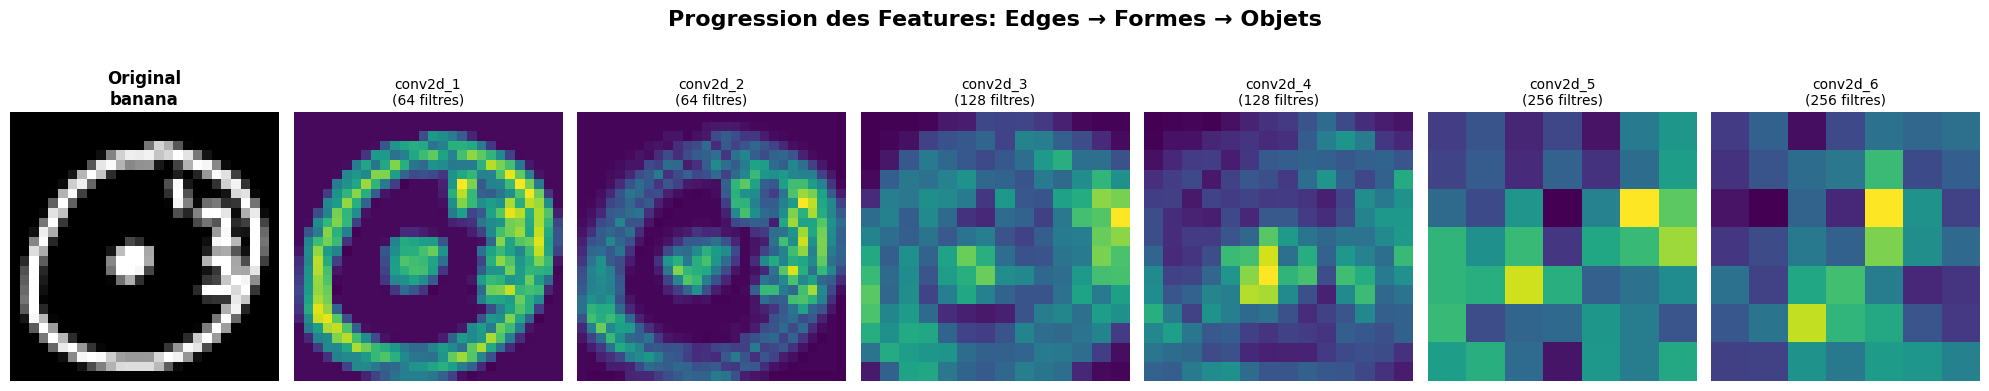

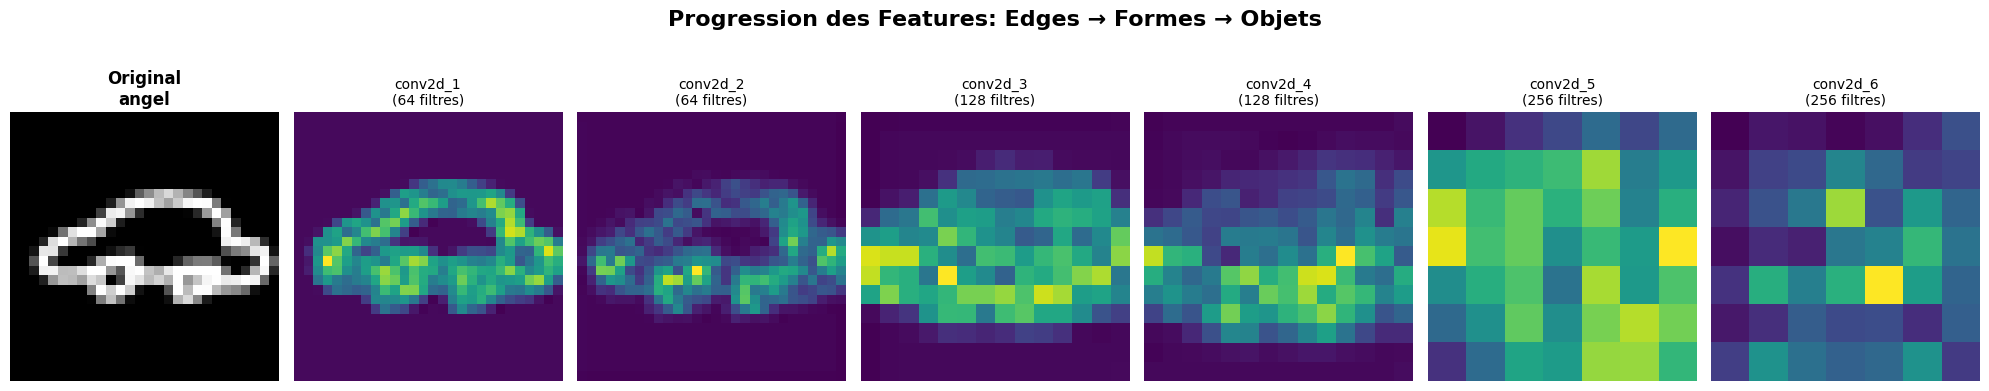

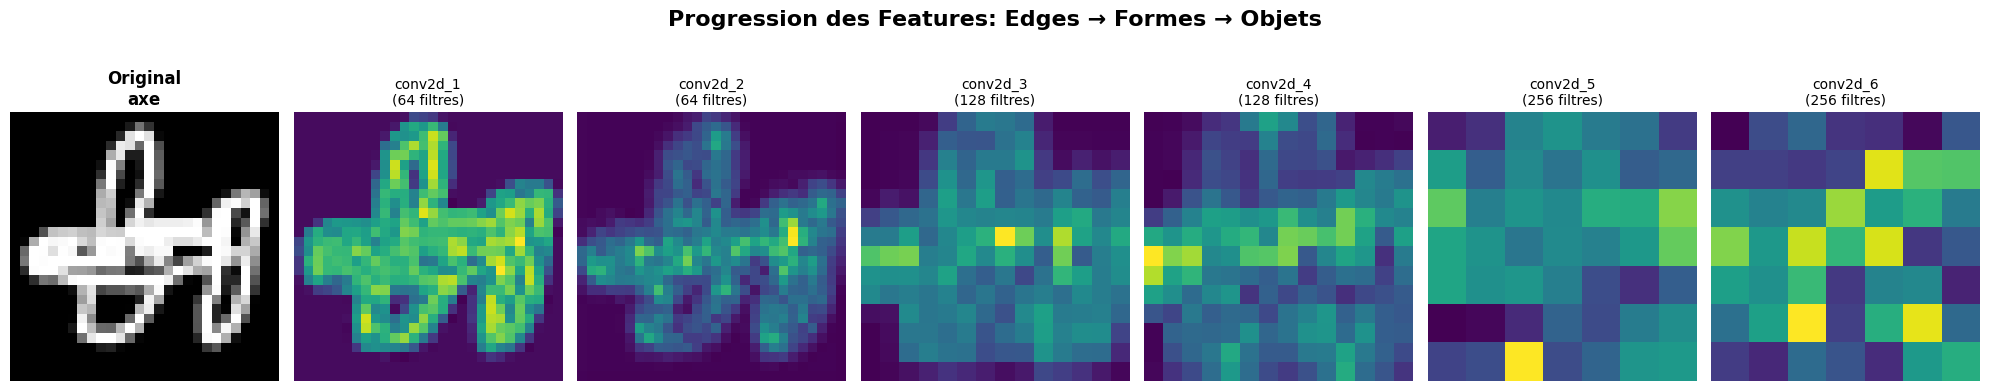

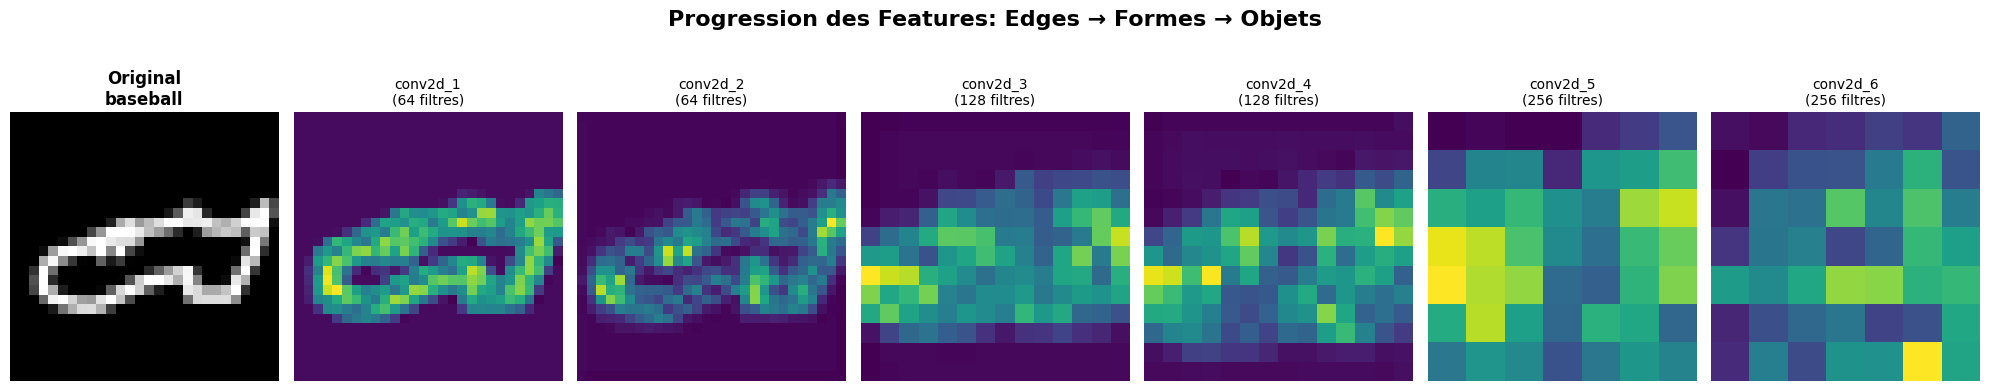

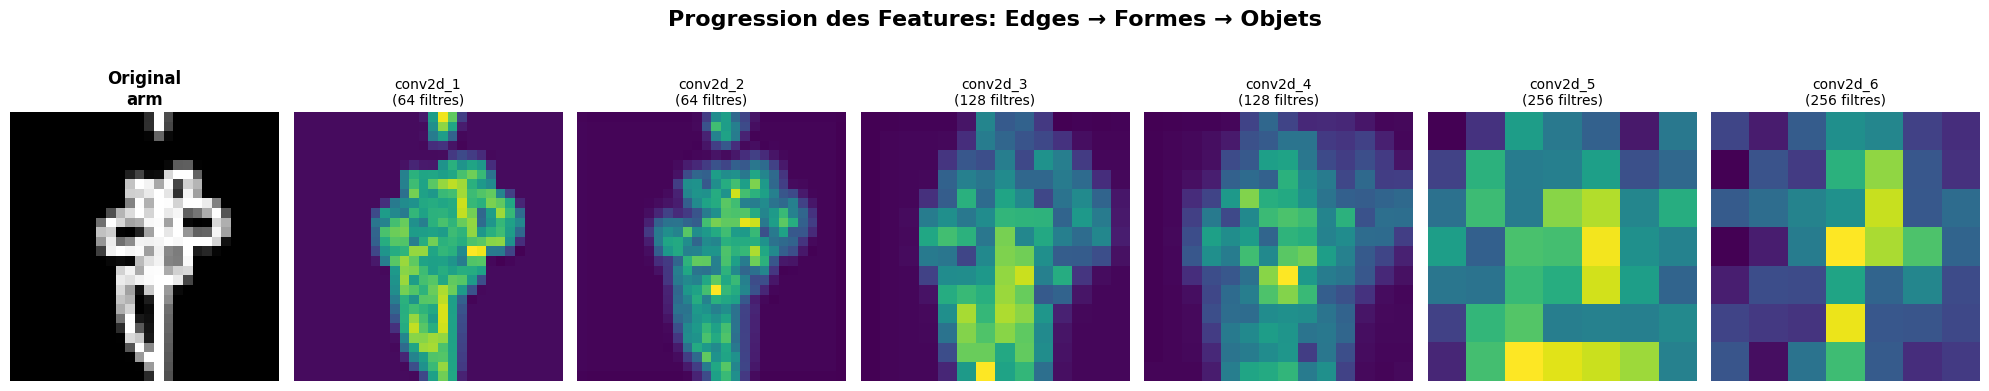

In [51]:
def visualize_layers_comparison(img, class_name):
    """
    Visualise un résumé de toutes les couches côte à côte.
    """
    img_batch = np.expand_dims(img, axis=0)
    activations = activation_model.predict(img_batch, verbose=0)
    
    fig = plt.figure(figsize=(20, 4))
    
    # Image originale
    ax = plt.subplot(1, len(layer_names) + 1, 1)
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Original\n{class_name}', fontsize=12, fontweight='bold')
    ax.axis('off')
    
    # Chaque couche (moyenne de tous les filtres)
    for i, (layer_name, activation) in enumerate(zip(layer_names, activations)):
        ax = plt.subplot(1, len(layer_names) + 1, i + 2)
        
        # Moyenne de tous les filtres
        mean_activation = np.mean(activation[0], axis=-1)
        
        ax.imshow(mean_activation, cmap='viridis')
        ax.set_title(f'{layer_name}\n({activation.shape[-1]} filtres)', 
                     fontsize=10)
        ax.axis('off')
    
    plt.suptitle('Progression des Features: Edges → Formes → Objets', 
                 fontsize=16, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

# Visualiser pour 5 exemples
for label, img in list(examples.items())[:5]:
    visualize_layers_comparison(img, class_names[label])

## 10. Filtres Appris par la Première Couche

Visualisation des poids/filtres appris par la première couche convolutionnelle.

Forme des filtres: (3, 3, 1, 64)
Nombre de filtres: 64


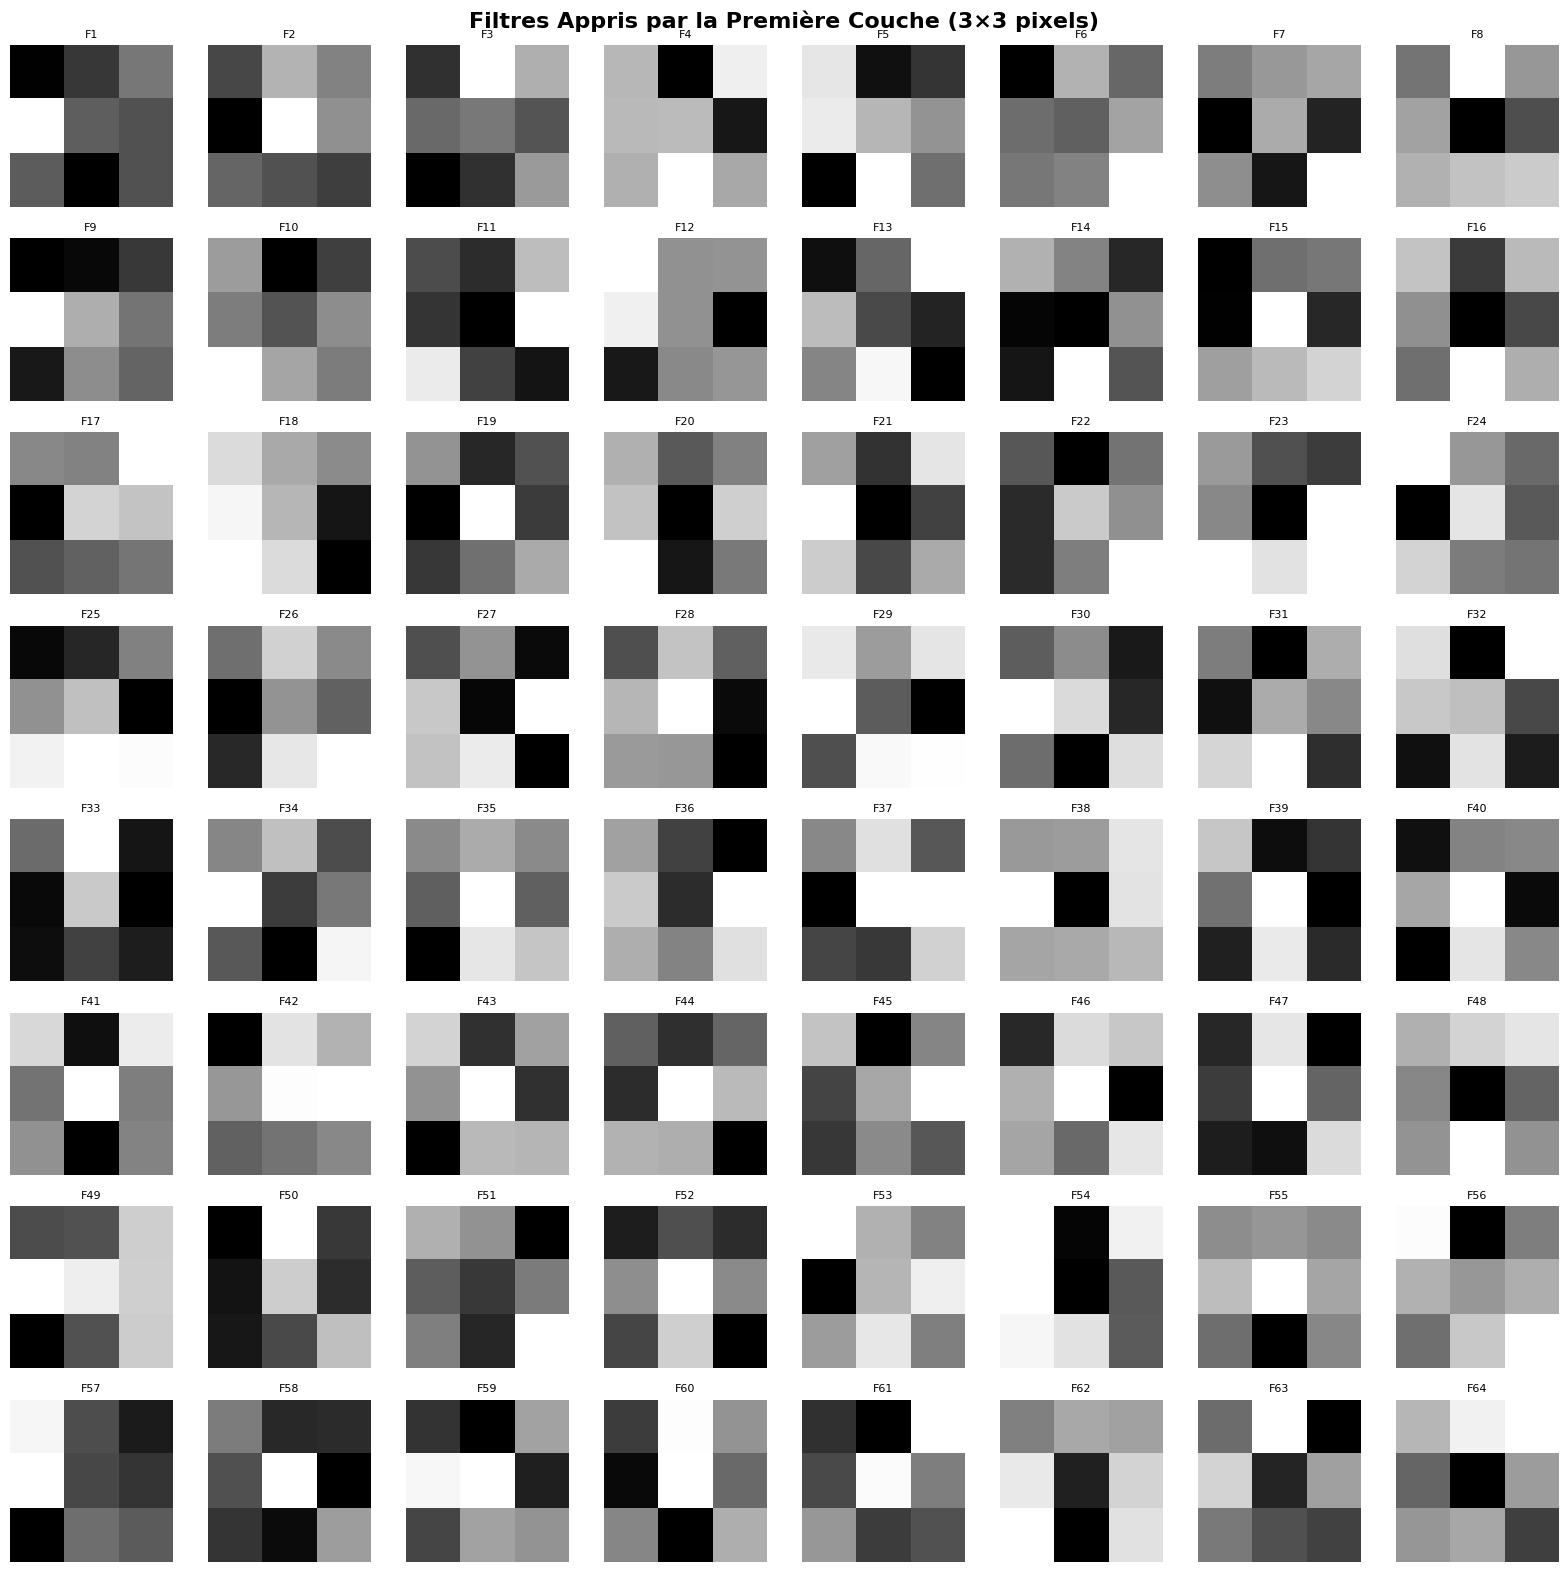


💡 Ces filtres détectent:
  - Edges horizontaux, verticaux, diagonaux
  - Lignes et courbes à différentes orientations
  - Contrastes locaux


In [52]:
# Récupérer les poids de la première couche
first_layer = model.get_layer('conv2d_1')
filters, biases = first_layer.get_weights()

print(f"Forme des filtres: {filters.shape}")  # (3, 3, 1, 64)
print(f"Nombre de filtres: {filters.shape[-1]}")

# Normaliser les filtres pour visualisation
f_min, f_max = filters.min(), filters.max()
filters_normalized = (filters - f_min) / (f_max - f_min)

# Visualiser les 64 premiers filtres
n_filters = 64
n_cols = 8
n_rows = n_filters // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 16))
axes = axes.ravel()

for i in range(n_filters):
    ax = axes[i]
    ax.imshow(filters_normalized[:, :, 0, i], cmap='gray')
    ax.set_title(f'F{i+1}', fontsize=8)
    ax.axis('off')

plt.suptitle('Filtres Appris par la Première Couche (3×3 pixels)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Ces filtres détectent:")
print("  - Edges horizontaux, verticaux, diagonaux")
print("  - Lignes et courbes à différentes orientations")
print("  - Contrastes locaux")

## 11. Analyse: Quels Filtres S'Activent le Plus?

Pour une image donnée, quels sont les filtres les plus actifs à chaque couche?

In [53]:
def analyze_most_active_filters(img, class_name, top_k=5):
    """
    Identifie les filtres les plus actifs pour une image.
    """
    img_batch = np.expand_dims(img, axis=0)
    activations = activation_model.predict(img_batch, verbose=0)
    
    print(f"\n🔍 Filtres les plus actifs pour: {class_name}\n")
    print("="*80)
    
    for layer_name, activation in zip(layer_names, activations):
        # Calculer l'activation moyenne par filtre
        mean_activations = np.mean(activation[0], axis=(0, 1))
        
        # Top K filtres
        top_indices = np.argsort(mean_activations)[-top_k:][::-1]
        
        print(f"\n{layer_name}:")
        for rank, idx in enumerate(top_indices, 1):
            print(f"  {rank}. Filtre {idx+1}: {mean_activations[idx]:.3f}")
    
    print("\n" + "="*80)

# Analyser 3 exemples
for label, img in list(examples.items())[:3]:
    analyze_most_active_filters(img, class_names[label])


🔍 Filtres les plus actifs pour: banana


conv2d_1:
  1. Filtre 20: 0.035
  2. Filtre 13: 0.030
  3. Filtre 10: 0.029
  4. Filtre 34: 0.029
  5. Filtre 8: 0.029

conv2d_2:
  1. Filtre 16: 0.036
  2. Filtre 38: 0.033
  3. Filtre 48: 0.023
  4. Filtre 12: 0.022
  5. Filtre 61: 0.022

conv2d_3:
  1. Filtre 23: 0.090
  2. Filtre 123: 0.081
  3. Filtre 45: 0.080
  4. Filtre 2: 0.080
  5. Filtre 5: 0.078

conv2d_4:
  1. Filtre 86: 0.090
  2. Filtre 110: 0.074
  3. Filtre 27: 0.072
  4. Filtre 95: 0.070
  5. Filtre 65: 0.067

conv2d_5:
  1. Filtre 175: 0.273
  2. Filtre 194: 0.248
  3. Filtre 151: 0.243
  4. Filtre 41: 0.216
  5. Filtre 23: 0.211

conv2d_6:
  1. Filtre 132: 0.163
  2. Filtre 240: 0.154
  3. Filtre 122: 0.124
  4. Filtre 74: 0.111
  5. Filtre 181: 0.104


🔍 Filtres les plus actifs pour: angel


conv2d_1:
  1. Filtre 10: 0.036
  2. Filtre 34: 0.027
  3. Filtre 9: 0.026
  4. Filtre 8: 0.026
  5. Filtre 20: 0.024

conv2d_2:
  1. Filtre 38: 0.023
  2. Filtre 12: 0.023
  3. Filtre 

## 12. Conclusion

### Observations:

1. **Couches 1-2 (Edges/Lignes)**:
   - Détectent des features de bas niveau
   - Edges horizontaux, verticaux, diagonaux
   - Haute résolution spatiale (28×28 → 14×14)

2. **Couches 3-4 (Formes Simples)**:
   - Combinent les edges en formes
   - Cercles, carrés, triangles
   - Résolution moyenne (14×14 → 7×7)

3. **Couches 5-6 (Parties d'Objets)**:
   - Features de haut niveau
   - Parties reconnaissables (yeux, roues, etc.)
   - Basse résolution (7×7 → 3×3)

4. **Couche Dense (Décision)**:
   - Combine toutes les features
   - Classification finale

### Hiérarchie apprise:
```
Image → Edges → Formes → Parties → Classe
```

Cette visualisation démontre comment le CNN apprend une représentation hiérarchique des dessins!